In [357]:
import warnings
warnings.filterwarnings('ignore')

import gzip
import numpy as np
import random
import os

from collections import Counter, defaultdict, namedtuple
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split

import tensorflow as tf
import nltk
from nltk.parse.stanford import StanfordDependencyParser

In [701]:
# global variables

path_to_jar = '/Users/hujiayu/Downloads/stanford-parser-full-2014-08-27/stanford-parser.jar'
path_to_models_jar = '/Users/hujiayu/Downloads/stanford-parser-full-2014-08-27/stanford-parser-3.4.1-models.jar'

mapping = {'nsubj':'subject', 'pobj':'object', 'prep':'preposition', 'aux':'auxiliary', 'dep':'undefined', \
           'det':'determiner', 'advmod':'adverbial', 'dobj': 'object', 'what\'s':'what', 'when\'s':'when',\
           'how\'s':'how'}

gloveFile = '../cs224u/vsmdata/glove.6B/glove.6B.50d.txt'
label_path = './classLabels.txt'
# trainKB_path = "./train.KBTraining_sample.txt"
trainKB_path = "./train.KBTraining.txt"

question_words = ('Who', 'who', 'what', 'What', 'why', 'Why', 'Where', 'where', \
                      'which', 'Which', 'how', 'How', 'when', 'When')
    
    
dim = 50

In [383]:
# this cell defines all the functions used below!
# Syntactic Features

# We use the shortest path between an entity mention and the question word in the dependency tree
# as input to the first channel.

"""
parser example: 'Who did shaq play for'

[(('play', 'VB'), 'aux', ('did', 'VBD')),
 (('play', 'VB'), 'nsubj', ('shaq', 'NNP')),
 (('play', 'VB'), 'prep', ('for', 'IN')),
 (('for', 'IN'), 'pobj', ('Who', 'WP'))]
 
"""
def set_parser(path_to_jar, path_to_models_jar):
    """
    imports parser and sets parser just once for future use
    """
    
    dependency_parser = StanfordDependencyParser(path_to_jar=path_to_jar, path_to_models_jar=path_to_models_jar)

    return dependency_parser
    
    
def get_tree(dependency_parser, sentence):
    """
    uses the dependency parser imported in set_parser to parse the given sentence into a tree
    returns a list of triples like the following:
    
    parser example: 'Who did shaq play for'

    [(('play', 'VB'), 'aux', ('did', 'VBD')),
     (('play', 'VB'), 'nsubj', ('shaq', 'NNP')),
     (('play', 'VB'), 'prep', ('for', 'IN')),
     (('for', 'IN'), 'pobj', ('Who', 'WP'))]

    """

    print("parsing sentence: ", sentence)
    result = dependency_parser.raw_parse(sentence)
    dep = result.__next__()
    
    return list(dep.triples())


def get_shortest_path(tree, mention, question_word, verbose = False):
    """
    this function gets the shortest path from a parsed tree from running
    
    result = dependency_parser.raw_parse('Who did shaq play for')
    dep = result.__next__()
    tree = list(dep.triples())
    
    mention = entity_word
    question_word = Who/Where/Why/How
    
    example of using this function:
    
    mention1 = 'shaq'
    mention2 = 'Who'
    result = dependency_parser.raw_parse('Who did shaq play for')
    dep = result.__next__()

    word_q, label_path, edge_path = get_shortest_path(list(dep.triples()), mention1, mention2)

    returns word_path, label_path and edge_path from two mentioned words
   
    """
    label_path = []
    edge_path = []
    visited = [0]*len(tree)
#     print('question word is: ', question_word)
#     print('tree looks like: ', tree)
#     print('mention word is: ', mention)
    
    def find_word(curr_w):
        if verbose: print("looking for word: ", curr_w)
        if curr_w == question_word: return True
        for idx, s in enumerate(tree):
            if visited[idx] == 0 and s[0][0] == curr_w:
                if verbose: print('found word here: ', s)
                if s[0][0] not in word_q:
                    word_q.append(s[0][0])
                label_path.append(s[1])
                edge_path.append('left')
                word_q.append(s[2][0])
                visited[idx] = 1
                return True
            if visited[idx] == 0 and s[2][0] == curr_w:
                if verbose: print('found word here: ', s)
                if s[2][0] not in word_q:
                    word_q.append(s[2][0])
                label_path.append(s[1])
                edge_path.append('right')
                word_q.append(s[0][0])
                visited[idx] = 1
                return True
        if verbose: print("couldn't find word: ", curr_w)
        return False
    
    word_q = [mention]
    
    T = True
    while T:   
        k = word_q[-1]
        if k == question_word: 
            T = False
        if find_word(k) == False: 
            if verbose: print('getting rid of word: ', k)
            word_q.pop()
            
    return word_q, label_path, edge_path
          
    
    
def syntactic_feature(word_q, label_path, edge_path, mention1, mention2):
    """
    this function takes in parsed word_path, label_path, edge_path from the above function and 
    returns list of features to be represented using GloVe and to be fed into the model as our features
    
    treats the path as a concatenation of vectors or words, dependency edge directions and dependency labels
    and feed it to the convolution layer
    
    extracting features from word_path, label_path, edge_path
    example:
    
    inputs: (from calling the above function)
    
    word_q: ['shaq', 'play', 'for', 'Who']
    label_path: ['nsubj', 'aux', 'prep', 'pobj']
    edge_path: ['right', 'left', 'left', 'left']
    
    output: ['left', 'nsubj', 'middle', 'play', 'middle', 'for', 'middle', 'pobj', 'right']

    """
    # if the three lists are of different length - be conservative here and cut them to the shortest length one
    sz = min(len(word_q), len(label_path), len(edge_path))
    
    def shrink_size(l, sz):
        if len(l) > sz:
            l = l[:sz]
        return l
    
    word_q = shrink_size(word_q, sz)
    label_path = shrink_size(label_path, sz)
    edge_path = shrink_size(edge_path, sz)
    
    entities = set([mention1, mention2])
    path = ['left']
    for idx, val in enumerate(word_q):
        if val in entities:
            path.append(label_path[idx])
            if idx == 0:
                path.append('middle')
        else:
            path.append(val)
            path.append('middle')
    path.append('right')
    return path
    
    
    
def load_GloVe(gloveFile):
    """
    loads pre_trained glove vectors
    
    example file name: 
    /Users/hujiayu/Documents/GitHub/cs224u/vsmdata/glove.6B/glove.6B.50d.txt
    
    can use one of the following dimensions:
    
    glove.6B.50d.txt
    glove.6B.100d.txt
    glove.6B.200d.txt
    glove.6B.300d.txt
    
    returns a dictionary with 
    key = word, and value = vector representation

    """
    print("Loading GloVe vectors..")
    f = open(gloveFile,'r')
    model = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding # shape is (50,)
    print("Done.",len(model)," words loaded!")
    return model
    
    
    
def get_word_repre(features, glove_model, dim):
    """
    This function takes in a list of words and represent them using 
    word vector representations from GloVe
    append to feature vector a random normal initialized vector is not found in glove
    
    example input: 
    
    path = ['left', 'nsubj', 'middle', 'play', 'middle', 'for', 'middle', 'pobj', 'right']
    
    returns np array matrix of dimension len(features) x dimension of GloVe used
    
    """
    res = []
    
    for w in features:
        try:
            res.append(glove_model[w])
        except KeyError:
            if w in mapping:
                res.append(glove_model[convert_words(mapping, w)])
            elif w.endswith('\'s'):
                w = w[:-2]
            else:
                # create random normal vector
                print('cannot find it in mapping, using random initializations instead ')
                res.append(np.random.normal(0,1,(dim,)))
    return np.array(res)


def convert_words(mapping, word):
    """
    since many of the syntax words cannot be found in glove
    convert to more general form such as nsubj - subject, and pobj - object
    """
    return mapping[word]


# Sentential Features
# According to paper, this channel takes the words in the sentence as input excluding the question 
# word and the entity mention. For example above: who did shaq first play for ? 
# the vectors for did, first, play and for are fed into this channel.

def sentential_feature(sentence, glove_model, mention1, mention2):
    """
    this function takes in the raw sentence, pre_trained glove model, and two mention words
    and outputs the glove word representation of all words in the sentence except the
    mention words
    assume input is a full sentence: 'Who did shaq first play for'
    """
    res = []
    entities = set([mention1, mention2])
    if sentence[-1] == '?':sentence = sentence[:-1]
    sentence = sentence.split()
    for w in sentence:
        if w not in entities:
            try:
                res.append(glove_model[w])
            except KeyError:
                if w in mapping:
                    res.append(glove_model[convert_words(mapping, w)])
                elif w.endswith('\'s'):
                    w = w[:-2]
                else:
                    print('cannot find %s in mapping, using random initializations instead '% w)
                    res.append(np.random.normal(0,1,(dim,)))
    res = np.array(res)
    return res, sentence

In [635]:
# This cell uses the functions defined above and calls to extracts all features from a given sentence
# can be used for debugging!

# dictionary of {sentenece:[mentions]} pairs
# sentences = {'Who did shaq first play for?':[('shaq','Who')]}
# sentences = {'what kind of money to take to bahamas?':[('bahamas','what')]}
# sentences = {'which kennedy died first?': [('kennedy','which')]}
# sentences = {'how much did adriana lima gain during pregnancy?': [('adriana lima','how')]}
# sentences = {'when did the new york knicks win a championship?':[('new york knicks','when')]}
# sentences = {'what\'s the national sport of puerto rico?': [('puerto rico','what\'s')]}
# sentences = {'what country is the grand bahama island in?':[('what', 'grand bahama island')]}
# sentence = 'Who did shaq first play for?'
# sentences = {'in what modern country is the yucatan peninsula located?': [('yucatan peninsula','what')]}
# mention1 = 'shaq'
# mention2 = 'Who'
sentences = [{'what\'s the national sport of puerto rico?': [('puerto rico','what\'s')]},
             {'what country is the grand bahama island in?':[('what', 'grand bahama island')]}]

# this fuction extracts all features and put into glove representations for an input of sentences and 
# their mentions
def extract_features(sentences, path_to_jar, path_to_models_jar, gloveFile, dim, verbose = False, maxl = 0):
    glove_model = load_GloVe(gloveFile)
    res = []
    question_words = ('Who', 'who', 'what', 'What', 'why', 'Why', 'Where', 'where', \
                      'which', 'Which', 'how', 'How', 'when', 'When')
    
    dependency_parser = set_parser(path_to_jar, path_to_models_jar)
   
    for pair_dict in sentences: # a pair
#       pair_dict = {'what\'s the national sport of puerto rico?': [('puerto rico','what\'s')]}
        entity_pairs = []
        for sentence in pair_dict:
            pairs = pair_dict[sentence]
            for pair in pairs:
                if pair[-1] not in question_words: 
                    if pair[-1].endswith('\'s'):
                        pair = list(pair)
                        pair[-1] = pair[-1][:-2]
                        pair = tuple(pair)
                    else:
                        # if question word is not on the second one - reverse order
                        pair = pair[::-1]
            # if it is a single word for the first entity instead of a phrase
                if len(pair[0].split()) == 1:
                    entity_pairs.append(pair)
                else:
                    # multiple mention pairs here
                    mention_pairs = []
                    for w in pair[0].split():
                        entity_pairs.append((w, pair[-1]))

#         print('entity pairs are: ', entity_pairs) 
        
        tree = get_tree(dependency_parser, sentence)
        for entity_pair in entity_pairs:
            total_feat = 0.
            (mention1, mention2) = entity_pair
            word_q, label_path, edge_path = get_shortest_path(tree, mention1, mention2, verbose = False)

#             print(word_q)
#             print(label_path)
#             print(edge_path)

            features = syntactic_feature(word_q, label_path, edge_path, mention1, mention2)
           
            syntactic_feat = get_word_repre(features, glove_model, dim)

            sentential_feat, sentence_words = sentential_feature(sentence, glove_model, mention1, mention2)
            if total_feat == 0:
                total_feat = np.concatenate((sentential_feat, syntactic_feat), axis = 0)
                total_feat = total_feat.reshape([1,-1]) #flatten to a one row vector
            else:
                tmp = np.concatenate((sentential_feat, syntactic_feat), axis = 0)
                tmp = tmp.reshape([1,-1])
                total_feat += tmp # addition of entities for the same sentence
        res.append(total_feat)
    print('done! length of total features extracted is: ', len(res))
    # res is a list of one 1 numpy arrays [(1,600),(1,800),...]
    # padding to make it same length
    if maxl == 0:
        maxl = max([x.shape[1] for x in res])

    def pad(total_feat, maxl):
        padded = []
        for r in total_feat:
            if r.shape[1] == maxl:
                padded.append(r.flatten())
            else:
                paddedl = min(r.shape[1], maxl)
                result = np.zeros([1,maxl])
                result[0,:paddedl] = r[0,:paddedl]
                padded.append(result.flatten())
        return np.array(padded)
    
    padded_res = pad(res, maxl)
    
    print('done padding! shape of total features extracted is: ', padded_res.shape)
    return padded_res, maxl
        
total_feat = extract_features(sentences, path_to_jar, path_to_models_jar, gloveFile, dim, verbose = False)

Loading GloVe vectors..
Done. 400000  words loaded!
parsing sentence:  what's the national sport of puerto rico?
parsing sentence:  what country is the grand bahama island in?
done! length of total features extracted is:  2
done padding! shape of total features extracted is:  (2, 700)


In [485]:
# this cell creates labels that map to each parsed sentence

def import_label_list(label_path):
    """
    This function takes in the path to the label.txt file and imports it in as a list of all the labels
    then build two dictionaries out of it
    labels_to_idx maps labels to its idx
    idx_to_labels maps idx back to its string labels
    """
    with open(label_path, 'r') as f:
        labels_list = f.readlines()
    labels_list = [x.strip() for x in labels_list]

    labels_to_idx = {}
    idx_to_labels = {}
    for idx, l in enumerate(labels_list):
        labels_to_idx.update({l:idx})
        idx_to_labels.update({idx:l})
        
    return labels_list, labels_to_idx, idx_to_labels

def encode(target, labels_to_idx):
    """
    takes in string labels and output its idx
    """
    target_ids = [labels_to_idx[l] for l in target]
    return target_ids

def decode(target_ids, idx_to_labels):
    """
    takes in idx and output its actual string labels
    """
    target = [idx_to_labels[l] for l in target_ids]
    return target


# this cell defines the train function using tensorflow neural networks

def flatten_tf_array(array):
    """
    returns a 2d array with input of any size
    """
    shape = array.get_shape().as_list()
    tmp = 1
    for s in shape[1:]:
        tmp *= s
    return tf.reshape(array, [shape[0], tmp])

def accuracy(predictions, target_ids, train= True):
    return 100. * (np.sum(np.argmax(np.array(predictions), 1) == target_ids))\
                / int(predictions.shape[0])
    
def fcnn(data, weights, bias):
     #A one layered fccd simply consists of a matrix multiplication
    return tf.matmul(flatten_tf_array(data), weights) + bias

    
def train(batch_size, labels_list, x_train, y_train_target_ids, x_test, y_test_target_ids, \
          num_steps = 20, display_step = 1, learning_rate = 0.01, layersz = 100):
    
    y_train = np.zeros([len(y_train_target_ids), len(labels_list)])

    for i in range(len(y_train_target_ids)):
        y_train[i, y_train_target_ids[i]] = 1 
        
    y_test = np.zeros([len(y_test_target_ids), len(labels_list)])

    for i in range(len(y_test_target_ids)):
        y_test[i, y_test_target_ids[i]] = 1 
        
    num_labels = len(labels_list) # 461
    len_feat = x_train.shape[1] # max feature length = feature length
    
    graph = tf.Graph()
    with graph.as_default():
        train_dataset = tf.placeholder(tf.float32, shape=(batch_size, 1, 1, len_feat))
        train_labels = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
        test_dataset = tf.placeholder(tf.float32, shape=(len(y_test_target_ids), 1,1, len_feat))
        test_labels = tf.placeholder(tf.float32, shape = (len(y_test_target_ids), num_labels))
  
        #tf.truncated_normal() is used for the weight matrix and tf.zeros() is used for the bias vector.
        weights1 = tf.Variable(tf.truncated_normal([len_feat, layersz]), tf.float32)
        bias1 = tf.Variable(tf.zeros([layersz]), tf.float32)
    
        weights2 = tf.Variable(tf.truncated_normal([layersz, num_labels]), tf.float32)
        bias2 = tf.Variable(tf.zeros([num_labels]), tf.float32)
  
        output = fcnn(train_dataset, weights1, bias1)
        logits = fcnn(output, weights2, bias2)
        
        output_test = fcnn(test_dataset, weights1, bias1)
        logits_test = fcnn(output_test, weights2, bias2)

        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=train_labels))
        loss_test = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits_test, labels=test_labels))
 
        optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
     
        train_prediction = tf.nn.softmax(fcnn(fcnn(train_dataset, weights1, bias1), weights2, bias2))
        test_prediction = tf.nn.softmax(fcnn(fcnn(test_dataset, weights1, bias1), weights2,bias2))

    trainloss = []
    testloss = []
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        x_train = np.reshape(x_train,(batch_size, 1,1, len_feat))
        y_train = np.reshape(y_train,(batch_size, num_labels))
        x_test = np.reshape(x_test,(len(y_test_target_ids), 1,1, len_feat))
        y_test = np.reshape(y_test,(len(y_test_target_ids), num_labels))
        print('Initialized...')
        for step in range(num_steps):
            _, l_train, predictions = session.run([optimizer, loss, train_prediction], \
                                            feed_dict={train_dataset:x_train, train_labels: y_train, \
                                                       test_dataset:x_test, test_labels: y_test})
            trainloss.append(l_train)
            if (step % display_step == 0):
                train_accuracy = accuracy(predictions, y_train_target_ids, train = True)

                _, l_test, predictions_test = session.run([optimizer, loss_test, test_prediction], \
                                    feed_dict={train_dataset: x_train, train_labels: y_train, \
                                               test_dataset: x_test, test_labels: y_test})
                testloss.append(l_test)
                
                test_accuracy = accuracy(predictions_test, y_test_target_ids, train = False)
                message = "step {:04d} : loss is {:06.2f}, accuracy on training set {:02.2f} %, accuracy on test set {:02.2f} %".\
                          format(step, l_train, train_accuracy, test_accuracy)
                print(message)
    return trainloss, testloss, predictions_test, weights1, bias1, weights2, bias2



In [523]:
# Now ready to connect everything together !!!! exciting !!!
    
sentences = {'what state does selena gomez?': [('selena gomez', 'what')], \
             'what kind of money to take to bahamas?':[('bahamas','what')],\
             'what country is the grand bahama island in?': [('grand bahama island', 'what')],\
             'which kennedy died first?': [('kennedy','which')],\
             'what country does iceland belong to?': [('iceland','what')]}

target = ['people.person.places_lived..people.place_lived.location','location.country.currency_used',\
         'location.location.containedby','fictional_universe.person_in_fiction.representations_in_fiction',\
         'book.book_subject.works']

sentences_test = {'what state does selena gomez?': [('selena gomez', 'what')], \
             'what kind of money to take to bahamas?':[('bahamas','what')],\
             'what country is the grand bahama island in?': [('grand bahama island', 'what')]}

target_test = ['people.person.places_lived..people.place_lived.location',\
               'location.country.currency_used','location.location.containedby']

x_train, maxl = extract_features(sentences, path_to_jar, path_to_models_jar, gloveFile, dim, verbose = False)
x_test,_ = extract_features(sentences_test, path_to_jar, path_to_models_jar, gloveFile, dim, verbose = False, maxl = maxl)
batch_size = 5
labels_list, labels_to_idx, idx_to_labels = import_label_list(label_path)
y_train_target_ids = encode(target, labels_to_idx)
y_test_target_ids = encode(target_test, labels_to_idx)
# target_labels = decode(y_train_target_ids, idx_to_labels)
loss_train, loss_test, predictions_test, weights1, bias1, weights2, bias2 = train(batch_size, labels_list, \
                                                                                  x_train, y_train_target_ids, \
                                                                                  x_test, y_test_target_ids, \
                                                                                  num_steps = 20, display_step = 1, \
                                                                                  learning_rate = 0.01, layersz = 50)


Loading GloVe vectors..
Done. 400000  words loaded!
parsing sentence:  what state does selena gomez?
parsing sentence:  what kind of money to take to bahamas?
parsing sentence:  what country is the grand bahama island in?
parsing sentence:  which kennedy died first?
parsing sentence:  what country does iceland belong to?
done! length of total features extracted is:  5
done padding! shape of total features extracted is:  (5, 800)
Loading GloVe vectors..
Done. 400000  words loaded!
parsing sentence:  what state does selena gomez?
parsing sentence:  what kind of money to take to bahamas?
parsing sentence:  what country is the grand bahama island in?
done! length of total features extracted is:  3
done padding! shape of total features extracted is:  (3, 800)
Initialized...
step 0000 : loss is 169.21, accuracy on training set 0.00 %, accuracy on test set 0.00 %
step 0001 : loss is 065.38, accuracy on training set 0.00 %, accuracy on test set 33.33 %
step 0002 : loss is 015.85, accuracy on t

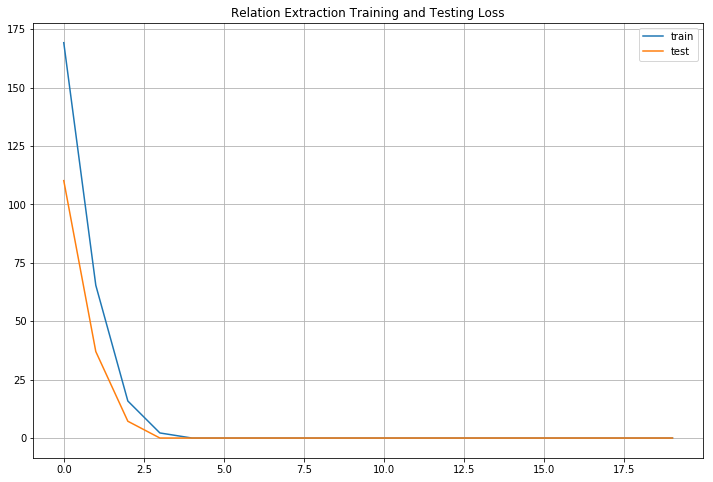

In [524]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
seaborn.mpl.rcParams['figure.figsize'] = (12.0, 8.0)
seaborn.mpl.rcParams['savefig.dpi'] = 90

x = np.array(range(20))

plt.grid(True)
plt.title('Relation Extraction Training and Testing Loss')
plt.plot(x, np.array(loss_train), label = 'train')
plt.plot(x, np.array(loss_test), label = 'test')
plt.legend(loc = 'upper right')
plt.show()

In [704]:
"""
want:

sentences = {'what state does selena gomez?': [('selena gomez', 'what')], \
             'what kind of money to take to bahamas?':[('bahamas','what')],\
             'what country is the grand bahama island in?': [('grand bahama island', 'what')],\
             'which kennedy died first?': [('kennedy','which')],\
             'what country does iceland belong to?': [('iceland','what')]}

target = ['people.person.places_lived..people.place_lived.location','location.country.currency_used',\
         'location.location.containedby','fictional_universe.person_in_fiction.representations_in_fiction',\
         'book.book_subject.works']

"""
import random
import collections
from sklearn.model_selection import train_test_split
def build_data(trainKB_path = trainKB_path, ratio = 0.8, sample_sz = -1):
    """
    import data from KBtraining.txt and parse into train and test set 
    """
    sentences_KB = []
    target_KB = []
    
    with open(trainKB_path, 'r') as f:
        text = f.readlines()
        for idx, t in enumerate(text):
            t = t.split('\n')[0]
            for i, val in enumerate(t.split()):
                if val.endswith('\'s'):
                    val = val[:-2]
                if val in question_words:
                    question_word = val
                
            if idx % 5 == 0: 
                tmp = {t:[(text[idx+1].split('\n')[0], question_word)]}
                
                sentences_KB.append(tmp)
                target_KB.append(text[idx+3].split('\n')[0])
                
    # prune out classes with less than 5 samples
    # and then do train-test split
    new_target = []
    new_sentence = []
    count_dict = collections.defaultdict(int)
    for t in target_KB:
        count_dict[t] += 1
    for idx, val in enumerate(target_KB):
        if count_dict[val] >= 50:
            new_target.append(val)
            new_sentence.append(sentences_KB[idx])

    X_train, X_test, y_train, y_test = train_test_split(
                                         new_sentence, new_target, test_size=0.33, random_state=42)
        
    return X_train, y_train, X_test, y_test
    
sentences_KB_train, target_KB_train, sentences_KB_test, target_KB_test = \
build_data(trainKB_path = trainKB_path, ratio = 0.8, sample_sz = -1)


In [705]:
# np.sum(np.array(encode(target_KB_test, labels_to_idx))==12)/len(target_KB_train)
print(len(np.unique(target_KB_train)))
print(len(np.unique(target_KB_test)))
print(len(target_KB_train))
print(len(target_KB_test))
# target_KB_train

14
14
709
350


In [706]:
# parsing the KB training dataset!

num_steps = 40

x_train, maxl = extract_features(sentences_KB_train, path_to_jar, path_to_models_jar, gloveFile, dim, verbose = False)
x_test, _ = extract_features(sentences_KB_test, path_to_jar, path_to_models_jar, gloveFile, dim, verbose = False, maxl = maxl)

batch_size = len(sentences_KB_train)
labels_list, labels_to_idx, idx_to_labels = import_label_list(label_path)

y_train_target_ids = encode(target_KB_train, labels_to_idx)
y_test_target_ids = encode(target_KB_test, labels_to_idx)



Loading GloVe vectors..
Done. 400000  words loaded!
parsing sentence:  what is there to see in barcelona?
parsing sentence:  who is martin luther king jr wife?
parsing sentence:  what kind of money does the philippines use?
parsing sentence:  what language do cyprus speak?
parsing sentence:  what to see in staten island new york?
parsing sentence:  what did robert koch do?
parsing sentence:  what did richard nixon do for a living before he became president?
parsing sentence:  what type of currency does brazil use?
parsing sentence:  what happened to rev. robert schuller?
parsing sentence:  where did martin luther king went to school?
parsing sentence:  what years have the giants won the world series?
parsing sentence:  what movie did rihanna play in?
parsing sentence:  where did apostle paul grow up?
parsing sentence:  who is golfer dustin johnson dating?
parsing sentence:  what was elijah mccoy famous for?
parsing sentence:  what to do in midland tx this weekend?
parsing sentence:  wh

parsing sentence:  what is anderson silva trained in?
cannot find it in mapping, using random initializations instead 
parsing sentence:  who played dorothy in the film wizard of oz?
parsing sentence:  what type of money do japanese use?
parsing sentence:  who did tebow get traded to?
cannot find it in mapping, using random initializations instead 
parsing sentence:  who was charles darwin married to?
cannot find it in mapping, using random initializations instead 
parsing sentence:  who did heinrich himmler marry?
parsing sentence:  which countries are part of the united kingdom?
parsing sentence:  who did mario lopez just marry?
parsing sentence:  what was marilyn monroe known for?
cannot find it in mapping, using random initializations instead 
parsing sentence:  what kind of money in aruba?
parsing sentence:  what to see in singapore at night?
parsing sentence:  what to do in palo alto ca with kids?
parsing sentence:  what kind of language does switzerland speak?
parsing sentence: 

parsing sentence:  what years the steelers won the super bowl?
parsing sentence:  what did ryan dunn died from?
parsing sentence:  what made roald dahl famous?
parsing sentence:  when was the last time the new england patriots won the superbowl?
parsing sentence:  what school did michael jordan play for?
parsing sentence:  where does jeb bush live?
parsing sentence:  where is belgium at?
parsing sentence:  what to see and do in malta?
parsing sentence:  what time does barnes and noble close on saturday?
cannot find it in mapping, using random initializations instead 
parsing sentence:  who plays the voice of lois griffin on family guy?
parsing sentence:  who plays captain kirk in 2009?
parsing sentence:  what movies has scarlett johansson in?
parsing sentence:  what kind of money does argentina use?
parsing sentence:  what kind of government does iran have today?
parsing sentence:  where did eleanor roosevelt go to school?
parsing sentence:  who played eowyn in the lord of the rings mo

parsing sentence:  what drugs were in whitney houston when she died?
parsing sentence:  who does david carr play for?
parsing sentence:  what language do they speak in iceland wikipedia?
parsing sentence:  where is burundi located on a map?
cannot find it in mapping, using random initializations instead 
parsing sentence:  where is christina aguilera from?
parsing sentence:  what currency do the ukraine use?
parsing sentence:  what currency is used in switzerland 2012?
parsing sentence:  what currency should i take to jamaica?
parsing sentence:  what currency does south africa have?
parsing sentence:  where to ski in andorra reviews?
parsing sentence:  where did charles drew go to college?
parsing sentence:  where was emperor hadrian born?
cannot find it in mapping, using random initializations instead 
parsing sentence:  who is ellen albertini dow?
parsing sentence:  what is the economy of china?
parsing sentence:  what do people from guam speak?
parsing sentence:  what's the egyptian

parsing sentence:  what does andy warhol do?
parsing sentence:  what is the official language spoken in mexico?
parsing sentence:  what to do downtown san francisco?
parsing sentence:  who was charlemagne's wife?
parsing sentence:  what state is kaplan university online located?
parsing sentence:  who is leann rimes with now?
parsing sentence:  who was the real erin brockovich?
parsing sentence:  who played darth vader in the original star wars movies?
parsing sentence:  what does tim gunn do for a living?
parsing sentence:  what is the political system in italy?
parsing sentence:  what type of legal system does italy have?
parsing sentence:  who is adam sandler?
parsing sentence:  what type of political system does russia have?
parsing sentence:  where did dr. martin luther king jr. go to school?
parsing sentence:  what type of monarchy did england have during the glorious revolution?
parsing sentence:  what events led to napoleon's downfall?
parsing sentence:  what kind of currency t

parsing sentence:  what type of cancer did huell howser die of?
parsing sentence:  what are the major languages spoken in italy?
parsing sentence:  what college did joe namath attend?
parsing sentence:  where did michael jordan play high school basketball?
parsing sentence:  what professional baseball team did michael jordan play for?
parsing sentence:  where do logan browning live?
parsing sentence:  what do australia call their money?
parsing sentence:  what team did john madden play football for?
parsing sentence:  what did robin gibb died from?
parsing sentence:  what movies has michael clarke duncan been in?
parsing sentence:  what disease did anne frank get?
parsing sentence:  what club did aguero play for before man city?
parsing sentence:  what town was abe lincoln born in?
cannot find it in mapping, using random initializations instead 
parsing sentence:  on what continent is canada found?
cannot find it in mapping, using random initializations instead 
parsing sentence:  who 

parsing sentence:  when was the last time the toronto maple leafs make the playoffs?
cannot find it in mapping, using random initializations instead 
parsing sentence:  where is el salvador located?
cannot find it in mapping, using random initializations instead 
parsing sentence:  what team does chris humphrey play for?
parsing sentence:  where is the fukushima daiichi located?
cannot find it in mapping, using random initializations instead 
parsing sentence:  who played captain kirk in star trek?
parsing sentence:  what form of government does brazil have?
parsing sentence:  what is the government of spain today?
parsing sentence:  what the currency in argentina?
parsing sentence:  what job did martin luther king jr have?
parsing sentence:  who plays the new michael myers?
parsing sentence:  where did kate middleton go to prep school?
parsing sentence:  what money does jamaica use?
parsing sentence:  where was selena gomez really born?
cannot find it in mapping, using random initiali

parsing sentence:  where are you if you're in khartoum?
cannot find you're in mapping, using random initializations instead 
parsing sentence:  who is francis bacon and what did he do?
cannot find it in mapping, using random initializations instead 
cannot find it in mapping, using random initializations instead 
parsing sentence:  what's sweden's currency?
parsing sentence:  who was darth vader in episode 3?
parsing sentence:  what movies did charlie hunnam play in?
parsing sentence:  what to see near sedona arizona?
parsing sentence:  what years have the steelers won the super bowl?
parsing sentence:  what happened after anne frank died?
parsing sentence:  who was the first wife of prophet muhammad?
parsing sentence:  what college did harry s. truman attend?
parsing sentence:  where is alexandria located?
cannot find it in mapping, using random initializations instead 
parsing sentence:  what school did martin luther king jr attend?
parsing sentence:  what was the cause of death of m

parsing sentence:  who is married to garry trudeau?
cannot find it in mapping, using random initializations instead 
cannot find it in mapping, using random initializations instead 
parsing sentence:  what money do japanese use?
parsing sentence:  what is henry clay known for?
cannot find it in mapping, using random initializations instead 
parsing sentence:  what kind of money does the ivory coast use?
parsing sentence:  where north dakota located?
parsing sentence:  who did jeremy lin sign with?
parsing sentence:  where george washington carver go to school?
parsing sentence:  who is cameron crowe?
parsing sentence:  where is oceania on a map?
parsing sentence:  who voiced meg in the pilot?
parsing sentence:  what was the soviet union?
parsing sentence:  where did anne frank live before the war?
parsing sentence:  who is darwin and what is his theory?
parsing sentence:  who makes lois griffin voice?
parsing sentence:  who was galileo galilei?
parsing sentence:  what was the last time

In [707]:
layersz = 800
num_steps = 100
learning_rate = 0.1
loss_train, loss_test, predictions_test, weights1, bias1, weights2, bias2 = \
train(batch_size, labels_list, x_train, y_train_target_ids, x_test, y_test_target_ids, \
      num_steps = num_steps, display_step = 1, learning_rate = learning_rate, layersz = layersz)


Initialized...
step 0000 : loss is 1092.78, accuracy on training set 0.99 %, accuracy on test set 15.71 %
step 0001 : loss is 1579.46, accuracy on training set 23.13 %, accuracy on test set 17.43 %
step 0002 : loss is 1827.54, accuracy on training set 27.50 %, accuracy on test set 23.14 %
step 0003 : loss is 1600.52, accuracy on training set 26.52 %, accuracy on test set 22.00 %
step 0004 : loss is 526.87, accuracy on training set 50.78 %, accuracy on test set 40.00 %
step 0005 : loss is 255.71, accuracy on training set 58.25 %, accuracy on test set 56.57 %
step 0006 : loss is 071.96, accuracy on training set 76.45 %, accuracy on test set 64.86 %
step 0007 : loss is 044.87, accuracy on training set 82.93 %, accuracy on test set 66.00 %
step 0008 : loss is 048.06, accuracy on training set 80.25 %, accuracy on test set 64.86 %
step 0009 : loss is 038.18, accuracy on training set 83.78 %, accuracy on test set 68.86 %
step 0010 : loss is 018.41, accuracy on training set 88.29 %, accuracy o

step 0090 : loss is 000.02, accuracy on training set 99.86 %, accuracy on test set 73.14 %
step 0091 : loss is 000.02, accuracy on training set 99.86 %, accuracy on test set 73.14 %
step 0092 : loss is 000.02, accuracy on training set 99.86 %, accuracy on test set 73.14 %
step 0093 : loss is 000.02, accuracy on training set 99.86 %, accuracy on test set 73.14 %
step 0094 : loss is 000.02, accuracy on training set 99.86 %, accuracy on test set 73.14 %
step 0095 : loss is 000.02, accuracy on training set 99.86 %, accuracy on test set 73.14 %
step 0096 : loss is 000.02, accuracy on training set 99.86 %, accuracy on test set 73.14 %
step 0097 : loss is 000.02, accuracy on training set 99.86 %, accuracy on test set 73.14 %
step 0098 : loss is 000.02, accuracy on training set 99.86 %, accuracy on test set 73.14 %
step 0099 : loss is 000.02, accuracy on training set 99.86 %, accuracy on test set 73.14 %


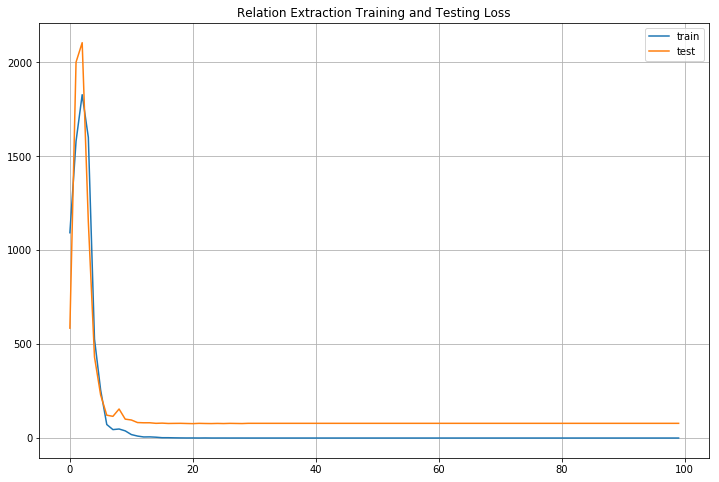

In [708]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
seaborn.mpl.rcParams['figure.figsize'] = (12.0, 8.0)
seaborn.mpl.rcParams['savefig.dpi'] = 90

x = np.array(range(num_steps))

plt.grid(True)
plt.title('Relation Extraction Training and Testing Loss')
plt.plot(x, np.array(loss_train), label = 'train')
plt.plot(x, np.array(loss_test), label = 'test')
plt.legend(loc = 'upper right')
plt.show()

In [725]:
y_pred = np.argmax(np.array(predictions_test), 1)
print(classification_report(y_test_target_ids, y_pred))
decode(y_test_target_ids[:14], idx_to_labels)

             precision    recall  f1-score   support

          0       0.89      0.61      0.72        41
          1       0.76      0.89      0.82        35
          6       0.00      0.00      0.00         0
         11       0.59      0.67      0.62        15
         12       0.93      0.82      0.87        34
         13       1.00      0.67      0.80        24
         15       0.00      0.00      0.00         0
         21       0.86      0.49      0.62        39
         25       0.64      0.72      0.68        32
         32       0.62      0.72      0.67        18
         40       0.82      1.00      0.90        14
         45       0.88      0.75      0.81        20
         47       0.71      0.79      0.75        19
         57       0.74      0.91      0.82        22
         59       0.78      0.70      0.74        20
         64       0.00      0.00      0.00         0
         71       0.00      0.00      0.00         0
        101       0.81      0.76      0.79   

['people.deceased_person.cause_of_death',
 'people.person.spouse_s..people.marriage.spouse',
 'location.country.official_language',
 'people.person.education..education.education.institution',
 'sports.pro_athlete.teams..sports.sports_team_roster.team',
 'travel.travel_destination.tourist_attractions',
 'location.location.containedby',
 'people.person.profession',
 'film.film_character.portrayed_in_films..film.performance.actor',
 'film.actor.film..film.performance.film',
 'people.person.spouse_s..people.marriage.spouse',
 'people.person.profession',
 'location.location.containedby',
 'people.person.place_of_birth']

In [726]:
# svm classifier
from sklearn.metrics import classification_report
from sklearn import svm
clf = svm.SVC()
clf.fit(x_train, y_train_target_ids)  
y_pred = clf.predict(x_test)
y_pred_train = clf.predict(x_train)
accu_test = np.sum(y_pred == y_test_target_ids)/len(y_pred)*1.
accu_train = np.sum(y_pred_train == y_train_target_ids)/len(y_train_target_ids)*1.
print(classification_report(y_test_target_ids, y_pred))

print(accu_test)
print(accu_train)

             precision    recall  f1-score   support

          0       0.65      0.76      0.70        41
          1       0.75      0.86      0.80        35
         11       0.57      0.87      0.68        15
         12       0.65      0.88      0.75        34
         13       1.00      0.71      0.83        24
         21       0.63      0.44      0.52        39
         25       0.33      0.69      0.45        32
         32       1.00      0.50      0.67        18
         40       0.93      1.00      0.97        14
         45       1.00      0.65      0.79        20
         47       0.50      0.21      0.30        19
         57       0.89      0.77      0.83        22
         59       0.90      0.45      0.60        20
        101       0.89      0.47      0.62        17

avg / total       0.73      0.67      0.67       350

0.6685714285714286
0.8025387870239774


In [ ]:
# sampled classes 10 samples/class

# people.person.places_lived..people.place_lived.location 
# sports.drafted_athlete.drafted..sports.sports_league_draft_pick.team 8 only
# book.book_subject.works
# location.location.adjoin_s..location.adjoining_relationship.adjoins
# people.person.profession
# government.governmental_jurisdiction.governing_officials..government.government_position_held.office_holder
# award.award_nominee.award_nominations..award.award_nomination.nominated_for
# location.country.form_of_government
# book.author.works_written
# celebrities.celebrity.sexual_relationships..celebrities.romantic_relationship.celebrity
# film.actor.film..film.performance.film
# location.country.currency_used (5 samples)
# location.location.containedby (4 samples)

In [727]:
# random forest classifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.datasets import make_classification

X, y = make_classification(n_samples=1000, n_features=4,
                            n_informative=2, n_redundant=0,
                            random_state=0, shuffle=False)
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(x_train, y_train_target_ids)
y_pred_train = clf.predict(x_train)
y_pred = clf.predict(x_test)
accu_train = np.sum(y_pred_train == y_train_target_ids)/len(y_train_target_ids)*1.
accu_test = np.sum(y_pred == y_test_target_ids)/len(y_pred)*1.
print(classification_report(y_test_target_ids, y_pred))

print(accu_test)
print(accu_train)

             precision    recall  f1-score   support

          0       0.29      0.12      0.17        41
          1       0.73      0.94      0.83        35
         11       0.00      0.00      0.00        15
         12       0.38      0.65      0.48        34
         13       0.75      0.62      0.68        24
         21       0.00      0.00      0.00        39
         25       0.20      0.88      0.32        32
         32       1.00      0.39      0.56        18
         40       1.00      0.07      0.13        14
         45       0.57      0.40      0.47        20
         47       0.92      0.63      0.75        19
         57       1.00      0.55      0.71        22
         59       0.55      0.55      0.55        20
        101       1.00      0.06      0.11        17

avg / total       0.53      0.44      0.41       350

0.44285714285714284
0.4682651622002821


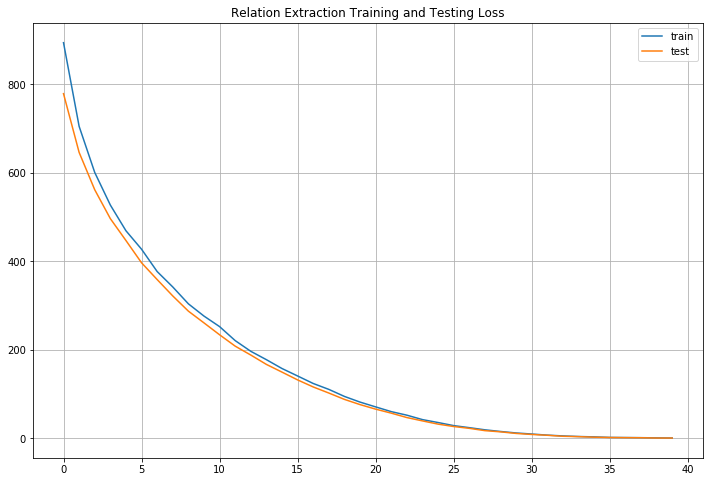

In [435]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# import seaborn
# seaborn.mpl.rcParams['figure.figsize'] = (12.0, 8.0)
# seaborn.mpl.rcParams['savefig.dpi'] = 90

# x = np.array(range(num_steps))

# plt.grid(True)
# plt.title('Relation Extraction Training and Testing Loss')
# plt.plot(x, np.array(loss_train), label = 'train')
# plt.plot(x, np.array(loss_test), label = 'test')
# plt.legend(loc = 'upper right')
# plt.show()

In [436]:
# predictions_test, weights1, bias1, weights2, bias2

In [672]:
from sklearn.metrics import f1_score


def get_f1_score(predictions, y_true):
    y_pred = np.argmax(np.array(predictions), 1)
    return f1_score(y_true, y_pred, average='micro')  

# f1_score = get_f1_score(predictions_test, y_test_target_ids)
# print(f1_score)
y_pred = np.argmax(np.array(predictions_test), 1)
print(decode(y_pred, idx_to_labels))
print(decode(y_test_target_ids, idx_to_labels))
print(loss_test)
# y_pred == y_test_target_ids
# why test loss is zero yet loss is converging ??

['aviation.aircraft_manufacturer.aircraft_models_made', 'people.person.spouse_s..people.marriage.from', 'tv.tv_character.appeared_in_tv_program..tv.regular_tv_appearance.series', 'people.person.spouse_s..people.marriage.from', 'food.beer.beer_style', 'location.location.adjoin_s..location.adjoining_relationship.adjoins', 'government.governmental_jurisdiction.governing_officials..government.government_position_held.office_holder', 'film.actor.film..film.performance.film', 'location.country.form_of_government', 'book.author.works_written', 'people.person.gender', 'location.country.form_of_government', 'visual_art.artwork.locations..visual_art.artwork_location_relationship.location', 'government.governmental_jurisdiction.governing_officials..government.government_position_held.office_holder', 'government.governmental_jurisdiction.governing_officials..government.government_position_held.office_holder', 'book.book_subject.works', 'film.film_subject.films', 'people.person.places_lived..people

In [463]:
r = np.array([[1,1,1,1,1,1,1,1]])
maxl = 7
paddedl = min(r.shape[1], maxl)
result = np.zeros([1,maxl])
print(result, paddedl, maxl)
print(result[0,:paddedl])
print(r[0,:paddedl])
result[0,:paddedl] = r[0,:paddedl]
result.flatten()

[[0. 0. 0. 0. 0. 0. 0.]] 7 7
[0. 0. 0. 0. 0. 0. 0.]
[1 1 1 1 1 1 1]
[778.74695, 646.0759, 561.7429, 496.49036, 447.0118, 396.69266, 358.81656, 321.81516, 287.4896, 260.9345, 234.07047, 208.3935, 188.27443, 167.12366, 149.70004, 132.09244, 116.17976, 102.44322, 88.096214, 76.33449, 66.06615, 57.034836, 47.08643, 39.50868, 32.227676, 26.83122, 22.714817, 17.520702, 14.809116, 11.208769, 8.917843, 7.068497, 4.8054256, 3.9677758, 2.713975, 2.0394342, 1.6972209, 1.4896119, 0.8417697, 0.843494]


In [ ]:
"""Example of Python client calling Knowledge Graph Search API."""
import json
import urllib

api_key = open('.api_key').read()
query = 'Taylor Swift'
service_url = 'https://kgsearch.googleapis.com/v1/entities:search'
params = {
    'query': query,
    'limit': 10,
    'indent': True,
    'key': api_key,
}
url = service_url + '?' + urllib.urlencode(params)
response = json.loads(urllib.urlopen(url).read())
for element in response['itemListElement']:
  print element['result']['name'] + ' (' + str(element['resultScore']) + ')'


In [519]:
# labels_to_idx['tv.tv_personality.tv_regular_appearances..tv.tv_regular_personal_appearance.seasons']
# idx_to_labels
len(labels_to_idx)

461

In [ ]:
# (2307, 1250) train